## Training LeNet on MNIST

### 1.) Preparing the Data

data/train.hdf5 and data/test.hdf5 will be generated.

### 2.)Defining the Network Architecture

In [1]:
using Mocha

Configuring Mocha...
 * CUDA       disabled by default
 * Native Ext disabled by default
Mocha configured, continue loading module...
DefaultBackend = Mocha.CPUBackend


In [2]:
data_layer=Mocha.HDF5DataLayer(name="train-data",source="data/train.txt",batch_size=64,shuffle=true)
conv1_layer=Mocha.ConvolutionLayer(name="conv1",n_filter=20,kernel=(5,5),bottoms=[:data],tops=[:conv1])

pool_layer=Mocha.PoolingLayer(name="pool1",kernel=(2,2),stride=(2,2),bottoms=[:conv1],tops=[:pool1])
conv2_layer=Mocha.ConvolutionLayer(name="conv2",kernel=(5,5),n_filter=50,bottoms=[:pool1],tops=[:conv2])
pool2_layer=Mocha.PoolingLayer(name="pool2",kernel=(2,2),stride=(2,2),bottoms=[:conv2],tops=[:pool2])

fc1_layer=Mocha.InnerProductLayer(name="ip1",output_dim=500,neuron=Mocha.Neurons.ReLU(),bottoms=[:pool2],tops=[:ip1])
fc2_layer  = InnerProductLayer(name="ip2", output_dim=10,bottoms=[:ip1], tops=[:ip2])

Mocha.InnerProductLayer(ip2)

#### 2.1) loss layer

In [3]:
loss_layer=Mocha.SoftmaxLossLayer(name="loss",bottoms=[:ip2,:label])

Mocha.SoftmaxLossLayer(loss)

#### 2.2) Configuring the Backend and Building the Network

In [4]:
backend=Mocha.CPUBackend()
Mocha.init(backend)

#### 2.3) common layer

In [5]:
common_layers=[conv1_layer,pool_layer,conv2_layer,
    pool2_layer,fc1_layer,fc2_layer]
net=Mocha.Net("mnist-train",backend,[data_layer,common_layers...,loss_layer])

[2018-08-16T14:57:48 | info | Mocha]: Constructing net mnist-train on Mocha.CPUBackend...
[2018-08-16T14:57:49 | info | Mocha]: Topological sorting 8 layers...
[2018-08-16T14:57:49 | info | Mocha]: Setup layers...
[2018-08-16T14:57:54 | info | Mocha]: Network constructed!


************************************************************
          NAME: mnist-train
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.HDF5DataLayer(train-data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 64)
         label: Blob(1 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 64)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 64)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 64)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
    

#### 2.4) Configuring the Solver

The behavior of the solver is specified by the following parameters:

* max_iter:
Max number of iterations the solver will run to train the network.

* regu_coef:
Regularization coefficient. By default, both the convolution layer and the inner product layer have L2 regularizers for their weights (and no regularization for bias). Those regularizations could be customized for each layer individually. The parameter here is a global scaling factor for all the local regularization coefficients.

* mom_policy:
This specifies the momentum policy used during training. Here we are using a fixed momentum policy of 0.9 throughout training. See the Caffe document for rules of thumb for setting the learning rate and momentum.

* lr_policy:
The learning rate policy. In this example, we are using the Inv policy with gamma = 0.001 and power = 0.75. This policy will gradually shrink the learning rate, by setting it to base_lr * (1 + gamma * iter)-power.

* load_from:
This can be a saved model file or a directory. For the latter case, the latest saved model snapshot will be loaded automatically before the solver loop starts. We will see in a minute how to configure the solver to save snapshots automatically during training.

This is useful to recover from a crash, to continue training with a larger max_iter or to perform fine tuning on some pre-trained models.

In [6]:
exp_dir="snapshots"
method=Mocha.SGD()
params=Mocha.make_solver_parameters(method,
    max_iter=1000,
    regu_coef=0.0005,
    mom_policy=Mocha.MomPolicy.Fixed(0.9),
    lr_policy=Mocha.LRPolicy.Inv(0.01,0.0001,0.75),
    load_from=exp_dir)
solver=Mocha.Solver(method,params)

Mocha.Solver{Mocha.SGD}(Mocha.SGD(), Dict{Symbol,Any}(Pair{Symbol,Any}(:lr_policy, Mocha.LRPolicy.Inv(0.01, 0.0001, 0.75)),Pair{Symbol,Any}(:max_iter, 1000),Pair{Symbol,Any}(:load_from, "snapshots"),Pair{Symbol,Any}(:regu_coef, 0.0005),Pair{Symbol,Any}(:mom_policy, Mocha.MomPolicy.Fixed(0.9))), Mocha.CoffeeLounge("", 1, :merge, Dict{AbstractString,Dict{Int64,AbstractFloat}}(), Mocha.CoffeeBreak[], false, 0, 0))

#### 2.5) Coffee Breaks for the Solver

Now our solver is ready to go. But in order to give it a healthy working plan, we provide it with some coffee breaks:

In [26]:
setup_coffee_lounge(solver,save_into="$exp_dir/statistics.jld",every_n_iter=100)

:merge

we allow the solver to have a coffee break after every 100 iterations so that it can give us a brief summary of the training process. By default TrainingSummary will print the loss function value on the last training mini-batch.

In [27]:
Mocha.add_coffee_break(solver,Mocha.TrainingSummary(),every_n_iter=100)

1-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)

We also add a coffee break to save a snapshot of the trained network every 5,000 iterations:

In [28]:
Mocha.add_coffee_break(solver,Mocha.Snapshot(exp_dir),every_n_iter=200)

2-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)
 Mocha.CoffeeBreak(Mocha.Snapshot("snapshots"), 200, 0)                

#### 2.6) evaluation

We will define a new network to perform the evaluation. The evaluation network will have exactly the same architecture, except with a different data layer that reads from the validation dataset instead of the training set. We also do not need the softmax loss layer as we will not train the validation network. Instead, we will add an accuracy layer on top, which will compute the classification accuracy.

In [29]:
data_layer_test=Mocha.HDF5DataLayer(name="test-data",source="data/test.txt",batch_size=100)
acc_layer=Mocha.AccuracyLayer(name="test-accuracy",bottoms=[:ip2,:label])
test_net=Mocha.Net("mnist-test",backend,[data_layer_test,common_layers...,acc_layer])

add_coffee_break(solver, ValidationPerformance(test_net), every_n_iter=1000)

[2018-08-16T11:39:35 | info | Mocha]: Constructing net mnist-test on Mocha.CPUBackend...
[2018-08-16T11:39:35 | info | Mocha]: Topological sorting 8 layers...
[2018-08-16T11:39:35 | info | Mocha]: Setup layers...
[2018-08-16T11:39:35 | info | Mocha]: Network constructed!


3-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### 2.7) training

In [30]:
Mocha.solve(solver,net)
destroy(net)
destroy(test_net)
shutdown(backend)

[2018-08-16T11:39:37 | info | Mocha]: Loading existing model from snapshots/snapshot-000100.jld
[2018-08-16T11:39:38 | info | Mocha]: Merging existing coffee lounge statistics in snapshots/statistics.jld
[2018-08-16T11:39:38 | info | Mocha]: Snapshot directory snapshots already exists
[2018-08-16T11:39:38 | info | Mocha]:  TRAIN iter=000100 obj_val=0.18518095
[2018-08-16T11:40:26 | info | Mocha]:  TRAIN iter=000200 obj_val=0.15600210
[2018-08-16T11:40:26 | info | Mocha]: Saving snapshot to snapshot-000200.jld...
[2018-08-16T11:41:13 | info | Mocha]:  TRAIN iter=000300 obj_val=0.16219212
[2018-08-16T11:41:57 | info | Mocha]:  TRAIN iter=000400 obj_val=0.19488037
[2018-08-16T11:41:57 | info | Mocha]: Saving snapshot to snapshot-000400.jld...
[2018-08-16T11:42:42 | info | Mocha]:  TRAIN iter=000500 obj_val=0.06549215
[2018-08-16T11:43:25 | info | Mocha]:  TRAIN iter=000600 obj_val=0.08592009
[2018-08-16T11:43:25 | info | Mocha]: Saving snapshot to snapshot-000600.jld...
[2018-08-16T11:44:

Dict{AbstractString,Array{Mocha.AbstractParameter,1}} with 0 entries

### 3) Using Saved Snapshots for Prediction

In [7]:
using Mocha
backend = Mocha.CPUBackend()
Mocha.init(backend)

mem_data = Mocha.MemoryDataLayer(name="data", tops=[:data], batch_size=1,
    data=Array[zeros(Float32, 28, 28, 1, 1)])
softmax_layer = Mocha.SoftmaxLayer(name="prob", tops=[:prob], bottoms=[:ip2])

# define common_layers as earlier

run_net = Mocha.Net("imagenet", backend, [mem_data, common_layers..., softmax_layer])

[2018-08-16T12:23:01 | info | Mocha]: Constructing net imagenet on Mocha.CPUBackend...
[2018-08-16T12:23:01 | info | Mocha]: Topological sorting 8 layers...
[2018-08-16T12:23:01 | info | Mocha]: Setup layers...
[2018-08-16T12:23:01 | info | Mocha]: Network constructed!


************************************************************
          NAME: imagenet
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.MemoryDataLayer(data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 1)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 1)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 1)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
         pool1: Blob(12 x 12 x 20 x 1)
    Ou

In [11]:
using  HDF5

load_snapshot(run_net, "snapshots/snapshot-001000.jld")
HDF5.h5open("data/test.hdf5") do f
    Mocha.get_layer(run_net,"data").data[1][:,:,1,1]=f["data"][:,:,1,1]
    println("Correct label index: ", Int64(f["label"][:,1][1]+1))
end

[2018-08-16T12:24:40 | info | Mocha]: Loading existing model from snapshots/snapshot-001000.jld
Correct label index: 9


In [12]:
Mocha.forward(run_net)
println()
println("Label probability vector:")
println(run_net.output_blobs[:prob].data)


Label probability vector:
Float32[1.81059f-7; 3.09175f-8; 1.01611f-6; 2.9032f-7; 2.12532f-8; 0.00321177; 2.17417f-6; 5.26392f-7; 0.996783; 1.0967f-6]


### 4.)Checking The Solver’s Progress with Learning Curves

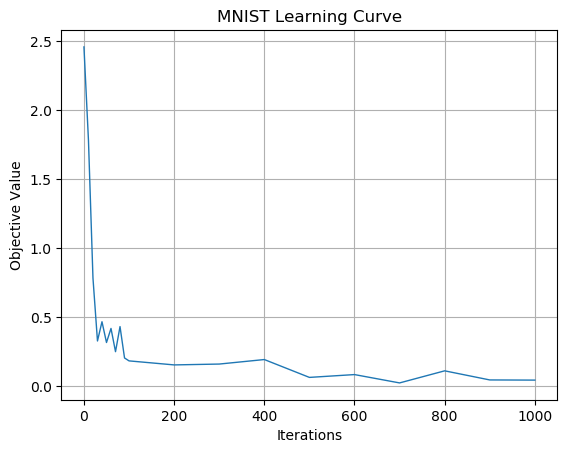

In [14]:
using PyPlot,JLD
stats=JLD.load("snapshots/statistics.jld")

tables=stats["statistics"]
ov = tables["obj_val"]
xy = sort(collect(ov))
x = [i for (i,j) in xy]
y = [j for (i,j) in xy]
x = convert(Array{Int64}, x)
y = convert(Array{Float64}, y)

raw = PyPlot.plot(x, y, linewidth=1, label="Raw")
PyPlot.xlabel("Iterations")
PyPlot.ylabel("Objective Value")
PyPlot.title("MNIST Learning Curve")
PyPlot.grid("on")